
# Loading Data

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
catalog = '/content/drive/MyDrive/groups_090.hdf5'
f = h5py.File(catalog, 'r')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/drive/MyDrive/groups_090.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
M_star = f['Subhalo/SubhaloMassType'][:,4]*1e10
pos  = f['Subhalo/SubhaloPos'][:]/1e3
vel = f['Subhalo/SubhaloVel'][:]
met = f['Subhalo/SubhaloStarMetallicity'][:]

In [2]:
def load_and_filter_data(file, mass_threshold=2e8):
    with h5py.File(file, 'r') as f:
        positions = f['Subhalo/SubhaloPos'][:]/1e3  # Convert to Mpc/h
        vel = f['Subhalo/SubhaloVel'][:]
        metallicities = f['Subhalo/SubhaloStarMetallicity'][:]
        masses = f['Subhalo/SubhaloMassType'][:,4]*1e10  # Stellar mass
        omega_m = f['Header'].attrs['Omega0']

    # Filter galaxies based on the stellar mass threshold
    mask = masses > mass_threshold
    positions = positions[mask]
    vel = vel[mask]
    metallicities = metallicities[mask]
    masses = masses[mask]

    return positions, vel, metallicities, masses, omega_m

In [3]:
def apply_periodic_boundary_conditions(positions, box_size):
    # Wrap positions to the box size
    positions = positions % box_size
    return positions

In [4]:
def minimum_image_distance(pos1, pos2, box_size):
    # Calculate the minimum image distance between two points
    delta = np.abs(pos1 - pos2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

In [5]:
from scipy.spatial import KDTree

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def create_edges_knn(points, k=6):
    edges = []
    edge_value = []

    # Create a KDTree for efficient nearest neighbor search
    point_tree = KDTree(points)

    for i in range(len(points)):
        # Query the k nearest neighbors for each point
        _, neighbors = point_tree.query(points[i], k=k+1)

        for j in neighbors[1:]:  # Skip the first neighbor because it's the point itself
            # Add an edge between the point and its neighbor
            edges.append([i, j])

            # Compute the distance between the points as the edge value
            edge_value.append(distance(points[i], points[j]))

    return [edges, edge_value]

In [6]:
from tqdm import tqdm
def min_distance(positions, box_size = 25):
    min_distance = np.inf
    max_distance = 0

    # Iterate over all pairs of galaxies
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            dist = minimum_image_distance(positions[i], positions[j], box_size)
            if dist < min_distance:
                min_distance = dist
            if dist > max_distance:
                max_distance = dist

    # Print the results
    print(f"Minimum distance: {min_distance} Mpc/h")
    print(f"Maximum distance: {max_distance} Mpc/h")

In [7]:
def minimum_image_distance_vectorized(positions, box_size = 25):
    num_galaxies = positions.shape[0]

    # Compute pairwise differences in each dimension
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]

    # Apply periodic boundary conditions
    diff = np.abs(diff)
    diff = np.where(diff > 0.5 * box_size, box_size - diff, diff)

    # Compute the Euclidean distance
    dist = np.sqrt(np.sum(diff ** 2, axis=-1))

    return dist

In [8]:
from tqdm import tqdm
from scipy.spatial import cKDTree
def create_edges_knn_pbc(points, box_size = 25, k=6):
    tree = KDTree(points, boxsize=box_size)

    edges = []
    edge_values = []
    '''
    distances = minimum_image_distance_vectorized(points, box_size)
    # Mask the diagonal (self-distances which are zero)
    np.fill_diagonal(distances, np.inf)
    # Get the minimum and maximum distances
    min_distance = np.min(distances)
    max_distance = np.max(np.triu(distances, k=1))
    print(min_distance, max_distance)
    '''

    min_distance = np.inf
    max_distance = 0
    large_distance_count = 0

    for i in range(len(points)):
        distances, neighbors = tree.query(points[i], k=k+1)
        for j, tree_dist in zip(neighbors[1:], distances[1:]):
            if j != i and j < len(points):
                actual_distance = minimum_image_distance(points[i], points[j], box_size)
                edges.append([i, j])
                edge_values.append(actual_distance)
                min_distance = min(min_distance, actual_distance)
                max_distance = max(max_distance, actual_distance)
    return np.array(edges), np.array(edge_values)


In [9]:
def create_points(positions, masses, vel, met):
    point_features = []
    for i, pos in enumerate(positions):
        #point_features.append(list(pos) + list(vel[i]) + [masses[i]] + [met[i]])
        point_features.append(list(pos) + [masses[i]] + [met[i]])
    return point_features

In [10]:
from torch_geometric.data import Data
import torch
def create_graph(file_path, k_val=6):
    positions, velocity, metallicities, masses, omega_m = load_and_filter_data(file_path)
    edges, edge_values = create_edges_knn_pbc(positions, 25, k_val)
    point_values = create_points(positions, masses, velocity, metallicities)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    point_values = torch.tensor(point_values, dtype=torch.float)
    edge_value = torch.tensor(edge_values, dtype=torch.float)

    return [point_values, edge_index, edge_value, omega_m]

In [11]:
def turn_data(graph):
    graph_data = Data(x=graph[0], edge_index=graph[1], edge_attr=graph[2], y = graph[3])
    return graph_data

In [12]:
def create_data(file_path, k_val=6):
    graph = create_graph(file_path, k_val)
    return turn_data(graph)

In [14]:
create_data('/content/drive/MyDrive/groups_090.hdf5', 6)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/drive/MyDrive/groups_090.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [13]:
def calculate_normalization_params(data_list):
    # Concatenate all node features and edge attributes
    all_x = torch.cat([data.x for data in data_list], dim=0)
    all_edge_attr = torch.cat([data.edge_attr for data in data_list], dim=0)

    # Calculate mean and std for node features and edge attributes
    x_mean, x_std = all_x.mean(dim=0), all_x.std(dim=0)
    edge_attr_mean, edge_attr_std = all_edge_attr.mean(dim=0), all_edge_attr.std(dim=0)

    return (x_mean, x_std), (edge_attr_mean, edge_attr_std)

def normalize_dataset(data_list, x_params, edge_attr_params):
    x_mean, x_std = x_params
    edge_attr_mean, edge_attr_std = edge_attr_params

    normalized_data_list = []
    for data in data_list:
        normalized_x = (data.x - x_mean) / (x_std + 1e-8)
        normalized_edge_attr = (data.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)

        # Create a new Data object with normalized features and original y value
        normalized_data = Data(x=normalized_x,
                               edge_index=data.edge_index,
                               edge_attr=normalized_edge_attr,
                               y=data.y)  # Preserve the original y value

        normalized_data_list.append(normalized_data)

    return normalized_data_list

In [14]:
import torch
import os
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
import h5py
directory = '/scratch/gpfs/hk4638/FinalData/NewData'
def load_all_graphs(directory, k_val=10, box_size=25):
    file_list = os.listdir(directory)
    data_list = []
    for file_name in tqdm(file_list):
        file_path = os.path.join(directory, file_name)
        graph_data = create_data(file_path, k_val)
        data_list.append(graph_data)
    return data_list

# Load all graphs
data_list = load_all_graphs(directory)

# Calculate normalization parameters based on all graphs
x_params, edge_attr_params = calculate_normalization_params(data_list)

# Normalize the dataset using the calculated parameters
normalized_data_list = normalize_dataset(data_list, x_params, edge_attr_params)

import torch
import numpy as np

def numpy_to_torch_float(data):
    if isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    elif isinstance(data, (np.float64, np.float32)):
        return torch.tensor(data, dtype=torch.float32)
    elif isinstance(data, torch.Tensor):
        return data.float()
    else:
        return data
        
def ensure_torch_float32(data):
    data.x = numpy_to_torch_float(data.x)
    data.edge_attr = numpy_to_torch_float(data.edge_attr)
    if hasattr(data, 'y'):
        data.y = numpy_to_torch_float(data.y)
    return data
    
normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

# Calculate the lengths for the 70-15-15 split
total_len = len(normalized_data_list)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Ensures all data is used

# Perform the split
train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]
/home/hk4638/.conda/envs/astridenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(ComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)

        self.convs = nn.ModuleList([
            GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            for _ in range(num_layers - 2)
        ])

        self.conv_last = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)

        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv_last(x, edge_index, edge_attr=edge_attr)

        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze()

In [16]:
def train_model(model, train_loader, val_loader, device, num_epochs=100, lr=0.001, load_best_model=False):
    model = model.to(device)
    
    if load_best_model:
        try:
            model.load_state_dict(torch.load('/home/hk4638/ondemand/data/sys/AstridLH/best_model.pth'))
            print("Loaded model from best_model.pth")
        except FileNotFoundError:
            print("best_model.pth not found. Starting with a new model.")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    best_model = None
    
    train_losses = []
    val_losses = []
    val_mses = []
    val_r2s = []
    
    try:
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            epoch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for data in epoch_pbar:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                epoch_pbar.set_postfix({'Train Loss': f'{loss.item():.4f}'})
            
            model.eval()
            val_loss = 0
            val_predictions = []
            val_true = []
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    out = model(data)
                    val_loss += criterion(out, data.y).item()
                    val_predictions.extend(out.cpu().numpy())
                    val_true.extend(data.y.cpu().numpy())
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_mse = mean_squared_error(val_true, val_predictions)
            val_r2 = r2_score(val_true, val_predictions)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_mses.append(val_mse)
            val_r2s.append(val_r2)
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}')
            print(f'  Val MSE: {val_mse:.4f}')
            print(f'  Val R2: {val_r2:.4f}')
            
            # Save the model after each epoch
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
            print(f'  Model saved as model_epoch_{epoch+1}.pth')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                torch.save(best_model, 'best_model.pth')
                print('  New best model saved as best_model.pth!')
            
            print()  # Add an empty line for better readability between epochs
    
    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving current model state...")
        torch.save(model.state_dict(), 'interrupted_model.pth')
        print("Model saved as interrupted_model.pth")
        if best_model is not None:
            model.load_state_dict(best_model)
        return model, train_losses, val_losses, val_mses, val_r2s
    
    # Load the best model if training completed without interruption
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, train_losses, val_losses, val_mses, val_r2s

In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Initialize model
in_channels = normalized_data_list[0].num_node_features
hidden_channels = 128
num_layers = 3
heads = 4
dropout_rate = 0.4

model = ComplexGAT(in_channels, hidden_channels, num_layers, heads, dropout_rate)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(model, train_loader, val_loader, device, num_epochs = 200, lr=0.001, load_best_model = True)

Loaded model from best_model.pth


Epoch 1/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0059]


Epoch 1/200:
  Train Loss: 0.0051
  Val Loss: 0.0058
  Val MSE: 0.0058
  Val R2: 0.5759
  Model saved as model_epoch_1.pth
  New best model saved as best_model.pth!



Epoch 2/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0038]


Epoch 2/200:
  Train Loss: 0.0048
  Val Loss: 0.0054
  Val MSE: 0.0053
  Val R2: 0.6092
  Model saved as model_epoch_2.pth
  New best model saved as best_model.pth!



Epoch 3/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0062]


Epoch 3/200:
  Train Loss: 0.0050
  Val Loss: 0.0061
  Val MSE: 0.0060
  Val R2: 0.5556
  Model saved as model_epoch_3.pth



Epoch 4/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0057]


Epoch 4/200:
  Train Loss: 0.0047
  Val Loss: 0.0063
  Val MSE: 0.0062
  Val R2: 0.5441
  Model saved as model_epoch_4.pth



Epoch 5/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0074]


Epoch 5/200:
  Train Loss: 0.0049
  Val Loss: 0.0056
  Val MSE: 0.0055
  Val R2: 0.5920
  Model saved as model_epoch_5.pth



Epoch 6/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0028]


Epoch 6/200:
  Train Loss: 0.0044
  Val Loss: 0.0062
  Val MSE: 0.0061
  Val R2: 0.5517
  Model saved as model_epoch_6.pth



Epoch 7/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0066]


Epoch 7/200:
  Train Loss: 0.0046
  Val Loss: 0.0071
  Val MSE: 0.0071
  Val R2: 0.4803
  Model saved as model_epoch_7.pth



Epoch 8/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0068]


Epoch 8/200:
  Train Loss: 0.0047
  Val Loss: 0.0055
  Val MSE: 0.0054
  Val R2: 0.6003
  Model saved as model_epoch_8.pth



Epoch 9/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0066]


Epoch 9/200:
  Train Loss: 0.0047
  Val Loss: 0.0071
  Val MSE: 0.0070
  Val R2: 0.4815
  Model saved as model_epoch_9.pth



Epoch 10/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0060]


Epoch 10/200:
  Train Loss: 0.0046
  Val Loss: 0.0059
  Val MSE: 0.0058
  Val R2: 0.5753
  Model saved as model_epoch_10.pth



Epoch 11/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0046]


Epoch 11/200:
  Train Loss: 0.0044
  Val Loss: 0.0060
  Val MSE: 0.0059
  Val R2: 0.5643
  Model saved as model_epoch_11.pth



Epoch 12/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0047]


Epoch 12/200:
  Train Loss: 0.0045
  Val Loss: 0.0067
  Val MSE: 0.0066
  Val R2: 0.5108
  Model saved as model_epoch_12.pth



Epoch 13/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0032]


Epoch 13/200:
  Train Loss: 0.0043
  Val Loss: 0.0057
  Val MSE: 0.0056
  Val R2: 0.5879
  Model saved as model_epoch_13.pth



Epoch 14/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0039]


Epoch 14/200:
  Train Loss: 0.0043
  Val Loss: 0.0060
  Val MSE: 0.0059
  Val R2: 0.5659
  Model saved as model_epoch_14.pth



Epoch 15/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0040]


Epoch 15/200:
  Train Loss: 0.0041
  Val Loss: 0.0064
  Val MSE: 0.0063
  Val R2: 0.5355
  Model saved as model_epoch_15.pth



Epoch 16/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0024]


Epoch 16/200:
  Train Loss: 0.0041
  Val Loss: 0.0064
  Val MSE: 0.0063
  Val R2: 0.5393
  Model saved as model_epoch_16.pth



Epoch 17/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0061]


Epoch 17/200:
  Train Loss: 0.0041
  Val Loss: 0.0070
  Val MSE: 0.0069
  Val R2: 0.4901
  Model saved as model_epoch_17.pth



Epoch 18/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0021]


Epoch 18/200:
  Train Loss: 0.0042
  Val Loss: 0.0063
  Val MSE: 0.0062
  Val R2: 0.5452
  Model saved as model_epoch_18.pth



Epoch 19/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0054]


Epoch 19/200:
  Train Loss: 0.0039
  Val Loss: 0.0061
  Val MSE: 0.0060
  Val R2: 0.5564
  Model saved as model_epoch_19.pth



Epoch 20/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0036]


Epoch 20/200:
  Train Loss: 0.0040
  Val Loss: 0.0060
  Val MSE: 0.0059
  Val R2: 0.5645
  Model saved as model_epoch_20.pth



Epoch 21/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0068]


Epoch 21/200:
  Train Loss: 0.0039
  Val Loss: 0.0063
  Val MSE: 0.0063
  Val R2: 0.5388
  Model saved as model_epoch_21.pth



Epoch 22/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0025]


Epoch 22/200:
  Train Loss: 0.0039
  Val Loss: 0.0063
  Val MSE: 0.0062
  Val R2: 0.5404
  Model saved as model_epoch_22.pth



Epoch 23/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0053]


Epoch 23/200:
  Train Loss: 0.0040
  Val Loss: 0.0077
  Val MSE: 0.0077
  Val R2: 0.4357
  Model saved as model_epoch_23.pth



Epoch 24/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0040]


Epoch 24/200:
  Train Loss: 0.0039
  Val Loss: 0.0071
  Val MSE: 0.0071
  Val R2: 0.4804
  Model saved as model_epoch_24.pth



Epoch 25/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0038]


Epoch 25/200:
  Train Loss: 0.0038
  Val Loss: 0.0067
  Val MSE: 0.0066
  Val R2: 0.5124
  Model saved as model_epoch_25.pth



Epoch 26/200: 100%|██████████| 22/22 [01:02<00:00,  2.84s/it, Train Loss=0.0049]


Epoch 26/200:
  Train Loss: 0.0037
  Val Loss: 0.0074
  Val MSE: 0.0073
  Val R2: 0.4600
  Model saved as model_epoch_26.pth



Epoch 27/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0033]


Epoch 27/200:
  Train Loss: 0.0037
  Val Loss: 0.0066
  Val MSE: 0.0065
  Val R2: 0.5202
  Model saved as model_epoch_27.pth



Epoch 28/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0031]


Epoch 28/200:
  Train Loss: 0.0038
  Val Loss: 0.0073
  Val MSE: 0.0072
  Val R2: 0.4691
  Model saved as model_epoch_28.pth



Epoch 29/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0034]


Epoch 29/200:
  Train Loss: 0.0036
  Val Loss: 0.0075
  Val MSE: 0.0075
  Val R2: 0.4465
  Model saved as model_epoch_29.pth



Epoch 30/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0035]


Epoch 30/200:
  Train Loss: 0.0038
  Val Loss: 0.0068
  Val MSE: 0.0067
  Val R2: 0.5066
  Model saved as model_epoch_30.pth



Epoch 31/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0040]


Epoch 31/200:
  Train Loss: 0.0036
  Val Loss: 0.0077
  Val MSE: 0.0077
  Val R2: 0.4332
  Model saved as model_epoch_31.pth



Epoch 32/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0045]


Epoch 32/200:
  Train Loss: 0.0035
  Val Loss: 0.0081
  Val MSE: 0.0081
  Val R2: 0.4061
  Model saved as model_epoch_32.pth



Epoch 33/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0046]


Epoch 33/200:
  Train Loss: 0.0035
  Val Loss: 0.0079
  Val MSE: 0.0078
  Val R2: 0.4221
  Model saved as model_epoch_33.pth



Epoch 34/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0038]


Epoch 34/200:
  Train Loss: 0.0035
  Val Loss: 0.0076
  Val MSE: 0.0076
  Val R2: 0.4429
  Model saved as model_epoch_34.pth



Epoch 35/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0044]


Epoch 35/200:
  Train Loss: 0.0034
  Val Loss: 0.0085
  Val MSE: 0.0084
  Val R2: 0.3802
  Model saved as model_epoch_35.pth



Epoch 36/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0036]


Epoch 36/200:
  Train Loss: 0.0034
  Val Loss: 0.0090
  Val MSE: 0.0090
  Val R2: 0.3386
  Model saved as model_epoch_36.pth



Epoch 37/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0032]


Epoch 37/200:
  Train Loss: 0.0036
  Val Loss: 0.0062
  Val MSE: 0.0061
  Val R2: 0.5542
  Model saved as model_epoch_37.pth



Epoch 38/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0029]


Epoch 38/200:
  Train Loss: 0.0034
  Val Loss: 0.0076
  Val MSE: 0.0075
  Val R2: 0.4464
  Model saved as model_epoch_38.pth



Epoch 39/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0038]


Epoch 39/200:
  Train Loss: 0.0035
  Val Loss: 0.0063
  Val MSE: 0.0062
  Val R2: 0.5416
  Model saved as model_epoch_39.pth



Epoch 40/200: 100%|██████████| 22/22 [01:02<00:00,  2.85s/it, Train Loss=0.0046]


Epoch 40/200:
  Train Loss: 0.0033
  Val Loss: 0.0074
  Val MSE: 0.0074
  Val R2: 0.4575
  Model saved as model_epoch_40.pth



Epoch 41/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0040]


Epoch 41/200:
  Train Loss: 0.0035
  Val Loss: 0.0069
  Val MSE: 0.0068
  Val R2: 0.4959
  Model saved as model_epoch_41.pth



Epoch 42/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0034]


Epoch 42/200:
  Train Loss: 0.0034
  Val Loss: 0.0076
  Val MSE: 0.0076
  Val R2: 0.4408
  Model saved as model_epoch_42.pth



Epoch 43/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0022]


Epoch 43/200:
  Train Loss: 0.0033
  Val Loss: 0.0072
  Val MSE: 0.0072
  Val R2: 0.4725
  Model saved as model_epoch_43.pth



Epoch 44/200: 100%|██████████| 22/22 [01:02<00:00,  2.86s/it, Train Loss=0.0024]


In [35]:
import optuna
import torch
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
import gc
import json
import pandas as pd

class Objective(object):
    def __init__(self, num_features, device, epochs, train_loader, val_loader):
        self.num_features = num_features
        self.device = device
        self.epochs = epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.best_trial_number = None
        self.best_val_loss = float('inf')

    def __call__(self, trial):
        # Define the directory for saving files
        save_dir = '/scratch/gpfs/hk4638/astrid_optimization'
        os.makedirs(save_dir, exist_ok=True)

        # Names of the files that will contain the losses, model weights, and hyperparameters
        fout = os.path.join(save_dir, f'loss_{trial.number}.txt')
        fmodel = os.path.join(save_dir, f'model_{trial.number}.pth')
        fhyper = os.path.join(save_dir, f'hyperparameters_{trial.number}.json')

        # Suggest hyperparameters
        hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128, 256])
        num_layers = trial.suggest_int('num_layers', 2, 6)
        heads = trial.suggest_categorical('heads', [4, 8, 16])
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

        # Save hyperparameters to a JSON file
        hyperparameters = {
            'hidden_channels': hidden_channels,
            'num_layers': num_layers,
            'heads': heads,
            'dropout_rate': dropout_rate,
            'lr': lr
        }
        with open(fhyper, 'w') as f:
            json.dump(hyperparameters, f, indent=4)

        # Generate the model architecture
        model = ComplexGAT(in_channels=self.num_features, hidden_channels=hidden_channels,
                           num_layers=num_layers, heads=heads,
                           dropout_rate=dropout_rate).to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        criterion = nn.MSELoss()
    
        def train():
            model.train()
            train_bar = tqdm(self.train_loader, leave=False, desc=f"Epoch {epoch+1}/{self.epochs}")
            for data in train_bar:
                data = data.to(self.device)
                out = model(data)
                loss = criterion(out.squeeze(), data.y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()

        def validate(loader):
            model.eval()
            total_loss = 0
            num_batches = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(self.device)
                    out = model(data)
                    loss = criterion(out.squeeze(), data.y)
                    total_loss += loss.item()
                    num_batches += 1
            return total_loss / num_batches

        # Train and validate model
        trial_best_val_loss = float('inf')
        for epoch in tqdm(range(self.epochs)):
            train()
            val_loss = validate(self.val_loader)
            
            if val_loss < trial_best_val_loss:
                trial_best_val_loss = val_loss
                torch.save(model.state_dict(), fmodel)
            
            with open(fout, 'a') as f:
                f.write(f'{epoch} {val_loss:.5e} {trial_best_val_loss:.5e}\n')

            # Handle pruning based on the intermediate value
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        # Update best overall model if this trial is the best so far
        if trial_best_val_loss < self.best_val_loss:
            self.best_val_loss = trial_best_val_loss
            self.best_trial_number = trial.number

            # Save the best trial number immediately
            with open(os.path.join(save_dir, 'best_trial.json'), 'w') as f:
                json.dump({
                    'best_trial_number': self.best_trial_number,
                    'best_val_loss': self.best_val_loss
                }, f, indent=4)

        # Print trial results
        print(f"\n--- Trial {trial.number} Results ---")
        print("Hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nCurrent Model Architecture:\n{model}")
        print(f"\nBest Validation Loss for this trial: {trial_best_val_loss:.5e}")
        print(f"Best Overall Validation Loss: {self.best_val_loss:.5e} (Trial {self.best_trial_number})")

        gc.collect()
        torch.cuda.empty_cache()
        return trial_best_val_loss

In [ ]:
# Set up the study
study_name = 'astrid_gnn_optimization'
n_trials = 50  # Total number of trials to run (including previous ones if resuming)
n_jobs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the directory for saving files
save_dir = '/scratch/gpfs/hk4638/astrid_optimization/'
os.makedirs(save_dir, exist_ok=True)

# Set up the storage
storage_name = os.path.join(save_dir, 'astrid_study.db')
storage = optuna.storages.RDBStorage(
    url=f"sqlite:///{storage_name}",
    engine_kwargs={"connect_args": {"timeout": 100}}
)

# Check if the study already exists
try:
    study = optuna.load_study(study_name=study_name, storage=storage)
    print(f"Resuming optimization from existing study '{study_name}'")
    print(f"Number of completed trials: {len(study.trials)}")
except KeyError:
    # If the study doesn't exist, create a new one
    study = optuna.create_study(study_name=study_name, storage=storage, 
                                sampler=optuna.samplers.TPESampler(n_startup_trials=10),
                                direction='minimize')
    print(f"Created new study '{study_name}'")

# Create the objective
objective = Objective(num_features=normalized_data_list[0].num_node_features, device=device, epochs=10, 
                      train_loader=train_loader, val_loader=val_loader)

# Calculate the number of trials to run
n_trials_to_run = max(0, n_trials - len(study.trials))

if n_trials_to_run > 0:
    print(f"Running {n_trials_to_run} additional trials...")
    study.optimize(objective, n_trials=n_trials_to_run, n_jobs=n_jobs)
else:
    print("No additional trials to run. The study has already completed the specified number of trials.")



[I 2024-08-16 00:23:15,857] A new study created in RDB with name: astrid_gnn_optimization


Created new study 'astrid_gnn_optimization'
Running 50 additional trials...


100%|██████████| 10/10 [08:01<00:00, 48.14s/it]             
[I 2024-08-16 00:31:17,480] Trial 0 finished with value: 0.01637849733233452 and parameters: {'hidden_channels': 64, 'num_layers': 4, 'heads': 4, 'dropout_rate': 0.00034387369884014696, 'lr': 1.9044244634951747e-05}. Best is trial 0 with value: 0.01637849733233452.



--- Trial 0 Results ---
Hyperparameters:
  hidden_channels: 64
  num_layers: 4
  heads: 4
  dropout_rate: 0.00034387369884014696
  lr: 1.9044244634951747e-05

Current Model Architecture:
ComplexGAT(
  (conv1): GATConv(5, 64, heads=4)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 64, heads=4)
  )
  (conv_last): GATConv(256, 64, heads=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Best Validation Loss for this trial: 1.63785e-02
Best Overall Validation Loss: 1.63785e-02 (Trial 0)


100%|██████████| 10/10 [19:11<00:00, 115.20s/it]            
[I 2024-08-16 00:50:29,683] Trial 1 finished with value: 0.010871088691055774 and parameters: {'hidden_channels': 128, 'num_layers': 2, 'heads': 16, 'dropout_rate': 0.46064895467319084, 'lr': 6.74975330801571e-05}. Best is trial 1 with value: 0.010871088691055774.



--- Trial 1 Results ---
Hyperparameters:
  hidden_channels: 128
  num_layers: 2
  heads: 16
  dropout_rate: 0.46064895467319084
  lr: 6.74975330801571e-05

Current Model Architecture:
ComplexGAT(
  (conv1): GATConv(5, 128, heads=16)
  (convs): ModuleList()
  (conv_last): GATConv(2048, 128, heads=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

Best Validation Loss for this trial: 1.08711e-02
Best Overall Validation Loss: 1.08711e-02 (Trial 1)


Epoch 10/10:  23%|██▎       | 5/22 [01:04<03:42, 13.08s/it]

In [36]:
'''
import os
import optuna

def reset_optuna_database(study_name, storage_path):
    """
    Reset the Optuna database by deleting the existing file and creating a new study.
    
    Args:
    study_name (str): The name of the study.
    storage_path (str): The path to the SQLite database file.
    
    Returns:
    optuna.Study: A new Optuna study object.
    """
    # Check if the database file exists
    if os.path.exists(storage_path):
        # Confirm with the user before deleting
        confirm = input(f"Are you sure you want to delete the existing study '{study_name}'? (y/n): ")
        if confirm.lower() == 'y':
            # Delete the existing database file
            os.remove(storage_path)
            print(f"Deleted existing database: {storage_path}")
        else:
            print("Database reset cancelled.")
            return None
    
    print(f"Created new study '{study_name}' at {storage_path}")
    return study
'''

In [37]:
'''
# Set up the study
study_name = 'astrid_gnn_optimization'
storage_path = '/scratch/gpfs/hk4638/astrid_optimization/astrid_study.db'

# Reset the database if desired
study = reset_optuna_database(study_name, storage_path)
'''

Are you sure you want to delete the existing study 'astrid_gnn_optimization'? (y/n):  y


Deleted existing database: /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db
Created new study 'astrid_gnn_optimization' at /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db


# Evaluating Model

In [24]:
in_channels = normalized_data_list[0].num_node_features
hidden_channels = 128
num_layers = 3
heads = 4
dropout_rate = 0.4
model = ComplexGAT(in_channels, hidden_channels, num_layers, heads, dropout_rate)
model.load_state_dict(torch.load('/home/hk4638/ondemand/data/sys/AstridLH/best_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = model

Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Test MSE: 0.0047, Test R2: 0.6252


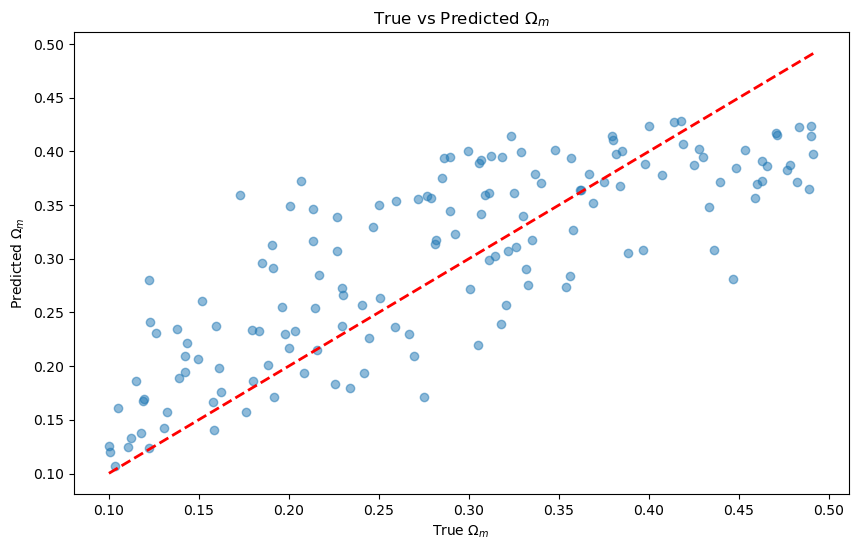

In [27]:
# Evaluate model
import matplotlib.pyplot as plt
test_predictions, test_true = evaluate_model(trained_model, test_loader, device)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(test_true, test_predictions, alpha=0.5)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'r--', lw=2)
plt.xlabel('True $\Omega_{m}$')
plt.ylabel('Predicted $\Omega_{m}$')
plt.title('True vs Predicted $\Omega_{m}$')
plt.show()